In [34]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split as tts, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, recall_score, f1_score, precision_score, roc_auc_score, roc_curve, auc
from lightgbm.sklearn import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import six
import sys
sys.modules['sklearn.externals.six'] = six
from imblearn.ensemble import EasyEnsembleClassifier
from imblearn.over_sampling import SVMSMOTE
from sklearn.svm import SVC

In [36]:
cleaned_train = pd.read_csv('cleaned_train_data.csv')
cleaned_train.head()

,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,city_development_index,training_hours,target
0,1.000000,0.0,3.000000,0.0,5.0,21.0,2.463052,4.274976,0.0,0.920,36.0,1.0
1,1.000000,1.0,3.000000,0.0,5.0,6.0,3.000000,5.000000,4.0,0.776,47.0,0.0
2,0.939181,1.0,0.000000,0.0,5.0,15.0,2.462749,4.129187,6.0,0.624,83.0,0.0
3,0.835441,1.0,1.318954,0.0,1.0,20.0,2.302724,5.000000,6.0,0.789,52.0,1.0
4,1.000000,0.0,3.000000,2.0,5.0,21.0,3.000000,1.000000,3.0,0.767,8.0,0.0


In [37]:
X = cleaned_train.drop('target',1)
y = cleaned_train.target

X_train,X_test,y_train,y_test = tts(X,y,test_size=0.25, random_state=42)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
svm_smote = SVMSMOTE(sampling_strategy='minority', random_state=42, k_neighbors=5)
X_svm_smote, y_svm_smote = svm_smote.fit_resample(X,y)

X_train_svm, X_test_svm, y_train_svm, y_test_svm = tts(X_svm_smote,y_svm_smote, test_size=0.25, random_state=42)

sc = StandardScaler()
X_train_svm = sc.fit_transform(X_train_svm)
X_test_svm = sc.transform(X_test_svm)

In [9]:
def evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)
    errors = abs(y_pred - y_test)
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print(classification_report(y_test,y_pred))
    print(confusion_matrix(y_test,y_pred))
    print('Test Recall Score = ',recall_score(y_test, y_pred))
    print('Test Precision Score = ',precision_score(y_test, y_pred))
    print('Test F1 score = ', f1_score(y_test,y_pred))

    return evaluate

In [10]:
def train_auc_roc_curve(model, X_test, y_test, X_train, y_train):
  base_fpr,base_tpr,base_threshold = roc_curve(y_train, model.predict(X_train))
  plt.plot([0,1])
  plt.plot(base_fpr,base_tpr)
  print("Train auc score :",auc(base_fpr,base_tpr))
  

  return train_auc_roc_curve

In [11]:
def test_auc_roc_curve(model, X_test, y_test, X_train, y_train):
  test_base_fpr,test_base_tpr,test_base_threshold = roc_curve(y_test, model.predict(X_test))
  plt.plot([0,1])
  plt.plot(test_base_fpr,test_base_tpr)
  print("Test auc score :",auc(test_base_fpr,test_base_tpr))
  

  return test_auc_roc_curve

In [25]:
y_svm_smote = pd.DataFrame(y_svm_smote)
one = y_svm_smote[y_svm_smote[0]==1]
zero =  y_svm_smote[y_svm_smote[0]==0]
y_svm_smote.value_counts()

1.0    14381
0.0    14381
dtype: int64

In [26]:
y_svm_smote

,0
0,1.0
1,0.0
2,0.0
3,1.0
4,0.0
...,...
28757,1.0
28758,1.0
28759,1.0
28760,1.0


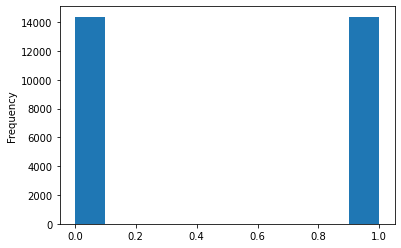

In [32]:
y_svm_smote[0].plot.hist()

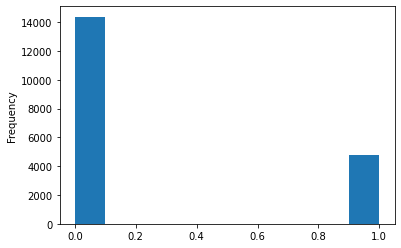

In [38]:
cleaned_train.target.plot.hist()

#Decision Tree Classifier

##1st attempt without SVMSmote

Average Error: 0.2071 degrees.
              precision    recall  f1-score   support

         0.0       0.87      0.86      0.86      3584
         1.0       0.59      0.61      0.60      1206

    accuracy                           0.79      4790
   macro avg       0.73      0.73      0.73      4790
weighted avg       0.80      0.79      0.79      4790

[[3067  517]
 [ 475  731]]
Test Recall Score =  0.6061359867330016
Test Precision Score =  0.5857371794871795
Test F1 score =  0.5957620211898941
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     10797
         1.0       1.00      0.99      1.00      3571

    accuracy                           1.00     14368
   macro avg       1.00      1.00      1.00     14368
weighted avg       1.00      1.00      1.00     14368

[[10796     1]
 [   19  3552]]
Train Recall Score =  0.9946793615233828
Train Precision Score =  0.9997185477061638
Train f1 score = 0.9971925884334644
Train auc score :

<function __main__.test_auc_roc_curve>

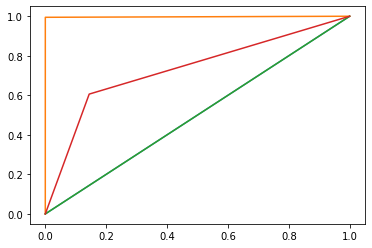

In [ ]:
dtree1 = DecisionTreeClassifier(random_state=42)
dtree1.fit(X_train, y_train)
evaluate(dtree1, X_test, y_test)
print("=======================================================================")

print(classification_report(y_train, dtree1.predict(X_train)))
print(confusion_matrix(y_train, dtree1.predict(X_train)))
print('Train Recall Score = ',recall_score(y_train, dtree1.predict(X_train)))
print('Train Precision Score = ',precision_score(y_train, dtree1.predict(X_train)))
print("Train f1 score =", f1_score(y_train, dtree1.predict(X_train)))
print("=======================================================================")

train_auc_roc_curve(dtree1, X_test, y_test, X_train, y_train)
print("=======================================================================")

test_auc_roc_curve(dtree1, X_test, y_test, X_train, y_train)

In [ ]:
dtree2 = DecisionTreeClassifier(random_state=42)
random_dtree_parameters = ({'criterion' : ['gini','entropy'],
                            'splitter' : ['best','random'],
                            'max_depth' : [8,10,12,15,20,24,32],
                            'min_samples_leaf' : [2,3,5],
                            'max_features' : ['auto', 'sqrt', 'log2']})

random_search_dtree = RandomizedSearchCV(dtree2, param_distributions= random_dtree_parameters, n_iter=100, cv=5)
random_search_dtree.fit(X_train,y_train)

random_search_dtree.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=12, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

Average Error: 0.1683 degrees.
              precision    recall  f1-score   support

         0.0       0.88      0.90      0.89      3584
         1.0       0.68      0.62      0.65      1206

    accuracy                           0.83      4790
   macro avg       0.78      0.76      0.77      4790
weighted avg       0.83      0.83      0.83      4790

[[3231  353]
 [ 453  753]]
Test Recall Score =  0.6243781094527363
Test Precision Score =  0.6808318264014467
Test F1 score =  0.6513840830449826
              precision    recall  f1-score   support

         0.0       0.91      0.94      0.92     10797
         1.0       0.78      0.71      0.75      3571

    accuracy                           0.88     14368
   macro avg       0.85      0.82      0.83     14368
weighted avg       0.88      0.88      0.88     14368

[[10097   700]
 [ 1031  2540]]
Train Recall Score =  0.711285354242509
Train Precision Score =  0.7839506172839507
Train f1 score = 0.7458522977536338
Train auc score : 

<function __main__.test_auc_roc_curve>

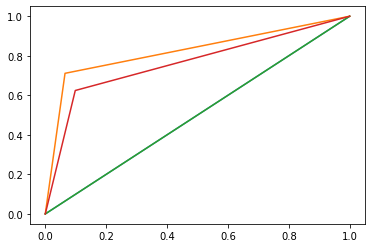

In [ ]:
dtree2 = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                                max_depth=12, max_features='sqrt', max_leaf_nodes=None,
                                min_impurity_decrease=0.0, min_impurity_split=None,
                                min_samples_leaf=2, min_samples_split=2,
                                min_weight_fraction_leaf=0.0, presort='deprecated',
                                random_state=42, splitter='best')
dtree2.fit(X_train, y_train)
evaluate(dtree2, X_test, y_test)
print("=======================================================================")

print(classification_report(y_train, dtree2.predict(X_train)))
print(confusion_matrix(y_train, dtree2.predict(X_train)))
print('Train Recall Score = ',recall_score(y_train, dtree2.predict(X_train)))
print('Train Precision Score = ',precision_score(y_train, dtree2.predict(X_train)))
print("Train f1 score =", f1_score(y_train, dtree2.predict(X_train)))
print("=======================================================================")

train_auc_roc_curve(dtree2, X_test, y_test, X_train, y_train)
print("=======================================================================")

test_auc_roc_curve(dtree2, X_test, y_test, X_train, y_train)

##3rd Attempt with SVMSmote

Average Error: 0.1478 degrees.
              precision    recall  f1-score   support

         0.0       0.86      0.85      0.85      3603
         1.0       0.85      0.86      0.85      3588

    accuracy                           0.85      7191
   macro avg       0.85      0.85      0.85      7191
weighted avg       0.85      0.85      0.85      7191

[[3053  550]
 [ 513 3075]]
Test Recall Score =  0.8570234113712375
Test Precision Score =  0.8482758620689655
Test F1 score =  0.8526272008872869
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     10778
         1.0       1.00      1.00      1.00     10793

    accuracy                           1.00     21571
   macro avg       1.00      1.00      1.00     21571
weighted avg       1.00      1.00      1.00     21571

[[10777     1]
 [   23 10770]]
Train Recall Score =  0.9978689891596405
Train Precision Score =  0.9999071581097391
Train f1 score = 0.9988870339454646
Train auc score :

<function __main__.test_auc_roc_curve>

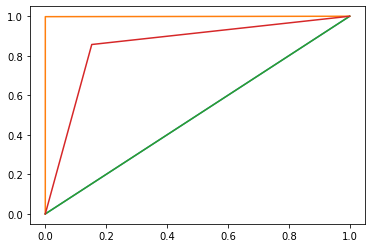

In [ ]:
dtree3 = DecisionTreeClassifier(random_state=42)
dtree3.fit(X_train_svm, y_train_svm)
evaluate(dtree3, X_test_svm, y_test_svm)
print("=======================================================================")

print(classification_report(y_train_svm, dtree3.predict(X_train_svm)))
print(confusion_matrix(y_train_svm, dtree3.predict(X_train_svm)))
print('Train Recall Score = ',recall_score(y_train_svm, dtree3.predict(X_train_svm)))
print('Train Precision Score = ',precision_score(y_train_svm, dtree3.predict(X_train_svm)))
print("Train f1 score =", f1_score(y_train_svm, dtree3.predict(X_train_svm)))
print("=======================================================================")

train_auc_roc_curve(dtree3, X_test_svm, y_test_svm, X_train_svm, y_train_svm)
print("=======================================================================")

test_auc_roc_curve(dtree3, X_test_svm, y_test_svm, X_train_svm, y_train_svm)

In [ ]:
dtree4 = DecisionTreeClassifier(random_state=42)
random_dtree_parameters = ({'criterion' : ['gini','entropy'],
                            'splitter' : ['best','random'],
                            'max_depth' : [8,10,12,15,20,24,32],
                            'min_samples_leaf' : [2,3,5],
                            'max_features' : ['auto', 'sqrt', 'log2']})

random_search_dtree = RandomizedSearchCV(dtree4, param_distributions= random_dtree_parameters, n_iter=100, cv=5)
random_search_dtree.fit(X_train_svm,y_train_svm)

random_search_dtree.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=20, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

Average Error: 0.1352 degrees.
              precision    recall  f1-score   support

         0.0       0.87      0.86      0.86      3603
         1.0       0.86      0.87      0.86      3588

    accuracy                           0.86      7191
   macro avg       0.86      0.86      0.86      7191
weighted avg       0.86      0.86      0.86      7191

[[3112  491]
 [ 481 3107]]
Test Recall Score =  0.8659420289855072
Test Precision Score =  0.8635352973874375
Test F1 score =  0.8647369885889229
              precision    recall  f1-score   support

         0.0       0.91      0.91      0.91     10778
         1.0       0.91      0.92      0.91     10793

    accuracy                           0.91     21571
   macro avg       0.91      0.91      0.91     21571
weighted avg       0.91      0.91      0.91     21571

[[9811  967]
 [ 917 9876]]
Train Recall Score =  0.9150375243213194
Train Precision Score =  0.91081803928802
Train f1 score = 0.9129229062673322
Train auc score : 0.912

<function __main__.test_auc_roc_curve>

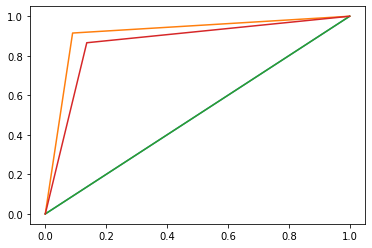

In [ ]:
dtree4 = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                                max_depth=20, max_features='sqrt', max_leaf_nodes=None,
                                min_impurity_decrease=0.0, min_impurity_split=None,
                                min_samples_leaf=3, min_samples_split=2,
                                min_weight_fraction_leaf=0.0, presort='deprecated',
                                random_state=42, splitter='best')
dtree4.fit(X_train_svm, y_train_svm)
evaluate(dtree4, X_test_svm, y_test_svm)
print("=======================================================================")

print(classification_report(y_train_svm, dtree4.predict(X_train_svm)))
print(confusion_matrix(y_train_svm, dtree4.predict(X_train_svm)))
print('Train Recall Score = ',recall_score(y_train_svm, dtree4.predict(X_train_svm)))
print('Train Precision Score = ',precision_score(y_train_svm, dtree4.predict(X_train_svm)))
print("Train f1 score =", f1_score(y_train_svm, dtree4.predict(X_train_svm)))
print("=======================================================================")

train_auc_roc_curve(dtree4, X_test_svm, y_test_svm, X_train_svm, y_train_svm)
print("=======================================================================")

test_auc_roc_curve(dtree4, X_test_svm, y_test_svm, X_train_svm, y_train_svm)

#Random Forest Classifier

##1st Attempt without SVMSmote

Average Error: 0.1572 degrees.
              precision    recall  f1-score   support

         0.0       0.87      0.92      0.90      3584
         1.0       0.73      0.60      0.66      1206

    accuracy                           0.84      4790
   macro avg       0.80      0.76      0.78      4790
weighted avg       0.84      0.84      0.84      4790

[[3310  274]
 [ 479  727]]
Test Recall Score =  0.6028192371475953
Test Precision Score =  0.7262737262737263
Test F1 score =  0.6588128681468056
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     10797
         1.0       1.00      1.00      1.00      3571

    accuracy                           1.00     14368
   macro avg       1.00      1.00      1.00     14368
weighted avg       1.00      1.00      1.00     14368

[[10792     5]
 [   15  3556]]
Train Recall Score =  0.9957994959395128
Train Precision Score =  0.998595900028082
Train f1 score = 0.9971957375210321
Train auc score : 

<function __main__.test_auc_roc_curve>

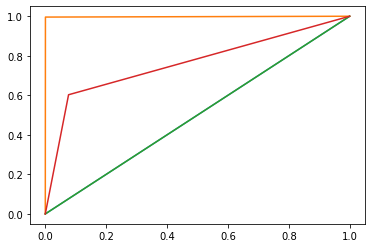

In [ ]:
rfc1 = RandomForestClassifier(random_state=42)
rfc1.fit(X_train, y_train)
evaluate(rfc1, X_test, y_test)
print("=======================================================================")

print(classification_report(y_train, rfc1.predict(X_train)))
print(confusion_matrix(y_train, rfc1.predict(X_train)))
print('Train Recall Score = ',recall_score(y_train, rfc1.predict(X_train)))
print('Train Precision Score = ',precision_score(y_train, rfc1.predict(X_train)))
print("Train f1 score =", f1_score(y_train, rfc1.predict(X_train)))
print("=======================================================================")

train_auc_roc_curve(rfc1, X_test, y_test, X_train, y_train)
print("=======================================================================")

test_auc_roc_curve(rfc1, X_test, y_test, X_train, y_train)

##2nd Attempt 

In [ ]:
n_estimators = [int (x) for x in np.linspace(100,1000,num=10)]
max_depth = [int(x) for x in np.linspace(15,25, num = 8)]
max_samples = [float(x) for x in np.linspace(0.1,0.99, num = 12)]
# provides parameters such as min_samples_leaf and max_depth to prevent a tree from overfiting.
rfc2 = RandomForestClassifier(random_state = 42)
random_rfc_parameters = ({'n_estimators' : n_estimators,
                          'criterion' : ['gini', 'entropy'],
                          'max_depth' : max_depth,
                          'min_samples_split' : [2,3,4],
                          'max_features' : ['auto'],
                          'min_samples_leaf' : [2,3,4],
                          'max_leaf_nodes' : [4,5,6,7],
                          'warm_start' : [True]})
  
random_search_rfc = RandomizedSearchCV(rfc2, param_distributions= random_rfc_parameters, n_iter=60, cv=5)
random_search_rfc.fit(X_train,y_train)


In [ ]:
random_search_rfc.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=7, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=True)

Average Error: 0.1944 degrees.
              precision    recall  f1-score   support

         0.0       0.80      0.99      0.88      3584
         1.0       0.91      0.25      0.40      1206

    accuracy                           0.81      4790
   macro avg       0.85      0.62      0.64      4790
weighted avg       0.83      0.81      0.76      4790

[[3554   30]
 [ 901  305]]
Test Recall Score =  0.25290215588723053
Test Precision Score =  0.9104477611940298
Test F1 score =  0.3958468526930564
              precision    recall  f1-score   support

         0.0       0.81      0.99      0.89     10797
         1.0       0.94      0.29      0.44      3571

    accuracy                           0.82     14368
   macro avg       0.88      0.64      0.67     14368
weighted avg       0.84      0.82      0.78     14368

[[10736    61]
 [ 2551  1020]]
Train Recall Score =  0.2856342761131336
Train Precision Score =  0.9435707678075855
Train f1 score = 0.4385210662080825
Train auc score 

<function __main__.test_auc_roc_curve>

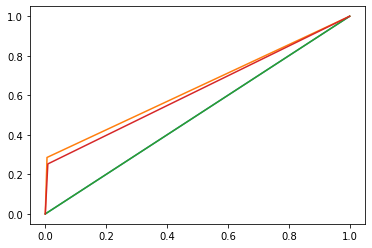

In [ ]:
rfc2 = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=7, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=True)

rfc2.fit(X_train, y_train)
evaluate(rfc2, X_test, y_test)
print("=======================================================================")

print(classification_report(y_train, rfc2.predict(X_train)))
print(confusion_matrix(y_train, rfc2.predict(X_train)))
print('Train Recall Score = ',recall_score(y_train, rfc2.predict(X_train)))
print('Train Precision Score = ',precision_score(y_train, rfc2.predict(X_train)))
print("Train f1 score =", f1_score(y_train, rfc2.predict(X_train)))
print("=======================================================================")

train_auc_roc_curve(rfc2, X_test, y_test, X_train, y_train)
print("=======================================================================")

test_auc_roc_curve(rfc2, X_test, y_test, X_train, y_train)

##3rd Attempt with SVMSmote

Average Error: 0.1032 degrees.
              precision    recall  f1-score   support

         0.0       0.89      0.91      0.90      3603
         1.0       0.90      0.89      0.90      3588

    accuracy                           0.90      7191
   macro avg       0.90      0.90      0.90      7191
weighted avg       0.90      0.90      0.90      7191

[[3267  336]
 [ 406 3182]]
Test Recall Score =  0.8868450390189521
Test Precision Score =  0.9044911881750994
Test F1 score =  0.8955811989867718
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     10778
         1.0       1.00      1.00      1.00     10793

    accuracy                           1.00     21571
   macro avg       1.00      1.00      1.00     21571
weighted avg       1.00      1.00      1.00     21571

[[10769     9]
 [   15 10778]]
Train Recall Score =  0.9986102103215047
Train Precision Score =  0.9991656623713729
Train f1 score = 0.9988878591288229
Train auc score :

<function __main__.test_auc_roc_curve>

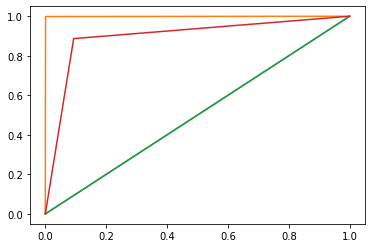

In [ ]:
rfc3 = RandomForestClassifier(random_state=42)
rfc3.fit(X_train_svm, y_train_svm)
evaluate(rfc3, X_test_svm, y_test_svm)
print("=======================================================================")

print(classification_report(y_train_svm, rfc3.predict(X_train_svm)))
print(confusion_matrix(y_train_svm, rfc3.predict(X_train_svm)))
print('Train Recall Score = ',recall_score(y_train_svm, rfc3.predict(X_train_svm)))
print('Train Precision Score = ',precision_score(y_train_svm, rfc3.predict(X_train_svm)))
print("Train f1 score =", f1_score(y_train_svm, rfc3.predict(X_train_svm)))
print("=======================================================================")

train_auc_roc_curve(rfc3, X_test_svm, y_test_svm, X_train_svm, y_train_svm)
print("=======================================================================")

test_auc_roc_curve(rfc3, X_test_svm, y_test_svm, X_train_svm, y_train_svm)

##4th attempt

In [ ]:
n_estimators = [int (x) for x in np.linspace(100,1000,num=10)]
max_depth = [int(x) for x in np.linspace(15,25, num = 8)]
max_samples = [float(x) for x in np.linspace(0.1,0.99, num = 12)]
# provides parameters such as min_samples_leaf and max_depth to prevent a tree from overfiting.
rfc4 = RandomForestClassifier(random_state = 42)
random_rfc_parameters = ({'n_estimators' : n_estimators,
                          'criterion' : ['gini', 'entropy'],
                          'max_depth' : max_depth,
                          'min_samples_split' : [2,3,4],
                          'max_features' : ['auto'],
                          'min_samples_leaf' : [2,3,4],
                          'max_leaf_nodes' : [4,5,6,7,8,9],
                          'warm_start' : [True],
                          'max_samples' : max_samples})
  
random_search_rfc = RandomizedSearchCV(rfc4, param_distributions= random_rfc_parameters, n_iter=60, cv=5)
random_search_rfc.fit(X_train_svm,y_train_svm)

random_search_rfc.best_estimator_


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=15, max_features='auto',
                       max_leaf_nodes=9, max_samples=0.6663636363636364,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=700,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=True)

Average Error: 0.1855 degrees.
              precision    recall  f1-score   support

         0.0       0.85      0.77      0.81      3603
         1.0       0.79      0.86      0.82      3588

    accuracy                           0.81      7191
   macro avg       0.82      0.81      0.81      7191
weighted avg       0.82      0.81      0.81      7191

[[2763  840]
 [ 494 3094]]
Test Recall Score =  0.8623188405797102
Test Precision Score =  0.7864768683274022
Test F1 score =  0.8226535495878756
              precision    recall  f1-score   support

         0.0       0.84      0.77      0.80     10778
         1.0       0.79      0.86      0.82     10793

    accuracy                           0.81     21571
   macro avg       0.82      0.81      0.81     21571
weighted avg       0.82      0.81      0.81     21571

[[8271 2507]
 [1533 9260]]
Train Recall Score =  0.8579634948577782
Train Precision Score =  0.7869465454236424
Train f1 score = 0.8209219858156028
Train auc score : 0.8

<function __main__.test_auc_roc_curve>

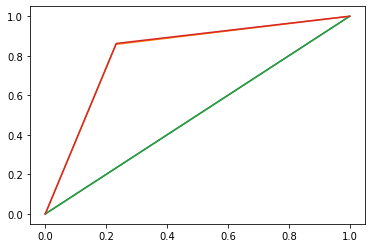

In [ ]:
rfc4 = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                              criterion='entropy', max_depth=15, max_features='auto',
                              max_leaf_nodes=9, max_samples=0.6663636363636364,
                              min_impurity_decrease=0.0, min_impurity_split=None,
                              min_samples_leaf=3, min_samples_split=4,
                              min_weight_fraction_leaf=0.0, n_estimators=700,
                              n_jobs=None, oob_score=False, random_state=42, verbose=0,
                              warm_start=True)
rfc4.fit(X_train_svm, y_train_svm)
evaluate(rfc4, X_test_svm, y_test_svm)
print("=======================================================================")

print(classification_report(y_train_svm, rfc4.predict(X_train_svm)))
print(confusion_matrix(y_train_svm, rfc4.predict(X_train_svm)))
print('Train Recall Score = ',recall_score(y_train_svm, rfc4.predict(X_train_svm)))
print('Train Precision Score = ',precision_score(y_train_svm, rfc4.predict(X_train_svm)))
print("Train f1 score =", f1_score(y_train_svm, rfc4.predict(X_train_svm)))
print("=======================================================================")

train_auc_roc_curve(rfc4, X_test_svm, y_test_svm, X_train_svm, y_train_svm)
print("=======================================================================")

test_auc_roc_curve(rfc4, X_test_svm, y_test_svm, X_train_svm, y_train_svm)

#Easy Ensemble Classifier

##1st Attempt without SVMSmote

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Average Error: 0.1712 degrees.
              precision    recall  f1-score   support

         0.0       0.92      0.84      0.88      3584
         1.0       0.63      0.79      0.70      1206

    accuracy                           0.83      4790
   macro avg       0.78      0.82      0.79      4790
weighted avg       0.85      0.83      0.83      4790

[[3012  572]
 [ 248  958]]
Test Recall Score =  0.7943615257048093
Test Precision Score =  0.6261437908496732
Test F1 score =  0.7002923976608187
              precision    recall  f1-score   support

         0.0       0.93      0.84      0.88     10797
         1.0       0.63      0.81      0.71      3571

    accuracy                           0.83     14368
   macro avg       0.78      0.82      0.80     14368
weighted avg       0.85      0.83      0.84     14368

[[9108 1689]
 [ 694 2877]]
Train Recall Score =  0.8056566788014562
Train Precision Score =  0.6300919842312747
Train f1 score = 0.7071402236696572
Train auc score : 0.8

<function __main__.test_auc_roc_curve>

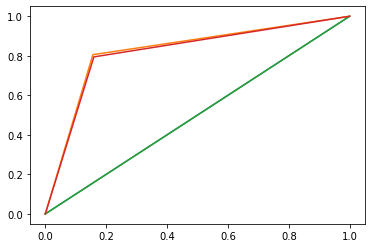

In [ ]:
easy1 = EasyEnsembleClassifier(random_state=42)
easy1.fit(X_train, y_train)
evaluate(easy1, X_test, y_test)
print("=======================================================================")

print(classification_report(y_train, easy1.predict(X_train)))
print(confusion_matrix(y_train, easy1.predict(X_train)))
print('Train Recall Score = ',recall_score(y_train, easy1.predict(X_train)))
print('Train Precision Score = ',precision_score(y_train, easy1.predict(X_train)))
print("Train f1 score =", f1_score(y_train, easy1.predict(X_train)))
print("=======================================================================")

train_auc_roc_curve(easy1, X_test, y_test, X_train, y_train)
print("=======================================================================")

test_auc_roc_curve(easy1, X_test, y_test, X_train, y_train)

##2nd Attempt

In [ ]:
easy2 = EasyEnsembleClassifier(random_state=42, verbose = False, n_jobs=1)

random_parameters = ({'n_estimators' : [10,50,100,150,200,250],
                      'sampling_strategy' : ['auto', 'not majority'],
                      'replacement' : [True, False],
                      'warm_start' : [True]})

random_search_easy = RandomizedSearchCV(easy2, param_distributions= random_parameters, n_iter=60, cv=5)
random_search_easy.fit(X_train,y_train)

random_search_easy.best_estimator_

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in vers

EasyEnsembleClassifier(base_estimator=None, n_estimators=10, n_jobs=1,
                       random_state=42, replacement=True,
                       sampling_strategy='not majority', verbose=False,
                       warm_start=True)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Average Error: 0.1718 degrees.
              precision    recall  f1-score   support

         0.0       0.84      0.95      0.89      3584
         1.0       0.77      0.46      0.57      1206

    accuracy                           0.83      4790
   macro avg       0.80      0.71      0.73      4790
weighted avg       0.82      0.83      0.81      4790

[[3415  169]
 [ 654  552]]
Test Recall Score =  0.4577114427860697
Test Precision Score =  0.7656033287101248
Test F1 score =  0.572911261027504
              precision    recall  f1-score   support

         0.0       0.85      0.96      0.90     10797
         1.0       0.79      0.50      0.61      3571

    accuracy                           0.84     14368
   macro avg       0.82      0.73      0.76     14368
weighted avg       0.84      0.84      0.83     14368

[[10337   460]
 [ 1801  1770]]
Train Recall Score =  0.4956594791374965
Train Precision Score =  0.7937219730941704
Train f1 score = 0.6102396138596793
Train auc score : 

<function __main__.test_auc_roc_curve>

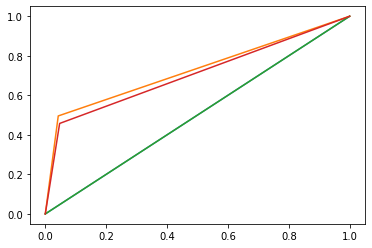

In [ ]:
easy2 = EasyEnsembleClassifier(base_estimator=None, n_estimators=10, n_jobs=1,
                                random_state=42, replacement=True,
                                sampling_strategy='not majority', verbose=False,
                                warm_start=True)
easy2.fit(X_train, y_train)
evaluate(easy2, X_test, y_test)
print("=======================================================================")

print(classification_report(y_train, easy2.predict(X_train)))
print(confusion_matrix(y_train, easy2.predict(X_train)))
print('Train Recall Score = ',recall_score(y_train, easy2.predict(X_train)))
print('Train Precision Score = ',precision_score(y_train, easy2.predict(X_train)))
print("Train f1 score =", f1_score(y_train, easy2.predict(X_train)))
print("=======================================================================")

train_auc_roc_curve(easy2, X_test, y_test, X_train, y_train)
print("=======================================================================")

test_auc_roc_curve(easy2, X_test, y_test, X_train, y_train)

##3rd Attempt with SVMSmote

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Average Error: 0.1627 degrees.
              precision    recall  f1-score   support

         0.0       0.82      0.86      0.84      3603
         1.0       0.85      0.81      0.83      3588

    accuracy                           0.84      7191
   macro avg       0.84      0.84      0.84      7191
weighted avg       0.84      0.84      0.84      7191

[[3098  505]
 [ 665 2923]]
Test Recall Score =  0.814659977703456
Test Precision Score =  0.852683780630105
Test F1 score =  0.8332383124287343
              precision    recall  f1-score   support

         0.0       0.83      0.86      0.84     10778
         1.0       0.86      0.82      0.84     10793

    accuracy                           0.84     21571
   macro avg       0.84      0.84      0.84     21571
weighted avg       0.84      0.84      0.84     21571

[[9298 1480]
 [1965 8828]]
Train Recall Score =  0.8179375521171129
Train Precision Score =  0.8564221963523477
Train f1 score = 0.8367375953746269
Train auc score : 0.840

<function __main__.test_auc_roc_curve>

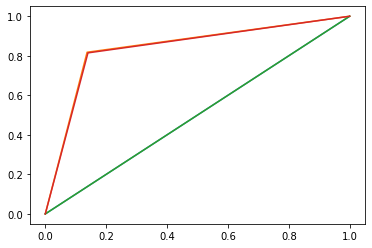

In [ ]:
easy3 = EasyEnsembleClassifier(random_state=42)
easy3.fit(X_train_svm, y_train_svm)
evaluate(easy3, X_test_svm, y_test_svm)
print("=======================================================================")

print(classification_report(y_train_svm, easy3.predict(X_train_svm)))
print(confusion_matrix(y_train_svm, easy3.predict(X_train_svm)))
print('Train Recall Score = ',recall_score(y_train_svm, easy3.predict(X_train_svm)))
print('Train Precision Score = ',precision_score(y_train_svm, easy3.predict(X_train_svm)))
print("Train f1 score =", f1_score(y_train_svm, easy3.predict(X_train_svm)))
print("=======================================================================")

train_auc_roc_curve(easy3, X_test_svm, y_test_svm, X_train_svm, y_train_svm)
print("=======================================================================")

test_auc_roc_curve(easy3, X_test_svm, y_test_svm, X_train_svm, y_train_svm)

##4th Attempt

In [ ]:
easy4 = EasyEnsembleClassifier(random_state=42, n_jobs=-1)

random_parameters = ({'n_estimators' : [10,50,100,150,200,250],
                      'sampling_strategy' : ['auto', 'not majority'],
                      'replacement' : [True, False],
                      'warm_start' : [True]})

random_search_easy = RandomizedSearchCV(easy4, param_distributions= random_parameters, n_iter=60, cv=5)
random_search_easy.fit(X_train_svm, y_train_svm)

random_search_easy.best_estimator_

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 24 is smaller than n_iter=60. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


EasyEnsembleClassifier(base_estimator=None, n_estimators=10, n_jobs=-1,
                       random_state=42, replacement=True,
                       sampling_strategy='not majority', verbose=0,
                       warm_start=True)

Average Error: 0.1537 degrees.
              precision    recall  f1-score   support

         0.0       0.83      0.87      0.85      3603
         1.0       0.87      0.82      0.84      3588

    accuracy                           0.85      7191
   macro avg       0.85      0.85      0.85      7191
weighted avg       0.85      0.85      0.85      7191

[[3152  451]
 [ 654 2934]]
Test Recall Score =  0.8177257525083612
Test Precision Score =  0.8667651403249631
Test F1 score =  0.8415316219704574
              precision    recall  f1-score   support

         0.0       0.83      0.88      0.85     10778
         1.0       0.87      0.82      0.85     10793

    accuracy                           0.85     21571
   macro avg       0.85      0.85      0.85     21571
weighted avg       0.85      0.85      0.85     21571

[[9458 1320]
 [1905 8888]]
Train Recall Score =  0.8234967108310942
Train Precision Score =  0.8706896551724138
Train f1 score = 0.8464358840055235
Train auc score : 0.8

<function __main__.test_auc_roc_curve>

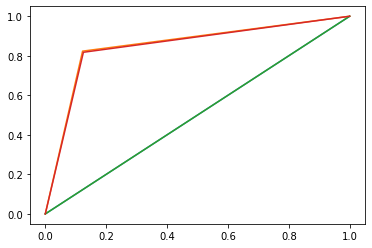

In [ ]:
easy4 = EasyEnsembleClassifier(base_estimator=None, n_estimators=200, n_jobs=-1,
                                random_state=42, replacement=True,
                                sampling_strategy='not majority', verbose=0,
                                warm_start=True)
easy4.fit(X_train_svm, y_train_svm)
evaluate(easy4, X_test_svm, y_test_svm)
print("=======================================================================")

print(classification_report(y_train_svm, easy4.predict(X_train_svm)))
print(confusion_matrix(y_train_svm, easy4.predict(X_train_svm)))
print('Train Recall Score = ',recall_score(y_train_svm, easy4.predict(X_train_svm)))
print('Train Precision Score = ',precision_score(y_train_svm, easy4.predict(X_train_svm)))
print("Train f1 score =", f1_score(y_train_svm, easy4.predict(X_train_svm)))
print("=======================================================================")

train_auc_roc_curve(easy4, X_test_svm, y_test_svm, X_train_svm, y_train_svm)
print("=======================================================================")

test_auc_roc_curve(easy4, X_test_svm, y_test_svm, X_train_svm, y_train_svm)

In [ ]:
easy = EasyEnsembleClassifier(base_estimator=None, n_estimators=200, n_jobs=1,
                       random_state=42, replacement=True,
                       sampling_strategy='not majority', verbose=0,
                       warm_start=True)
easy.fit(X_train_svm, y_train_svm)
evaluate(easy, X_test_svm, y_test_svm)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Average Error: 0.1537 degrees.
              precision    recall  f1-score   support

         0.0       0.83      0.87      0.85      3603
         1.0       0.87      0.82      0.84      3588

    accuracy                           0.85      7191
   macro avg       0.85      0.85      0.85      7191
weighted avg       0.85      0.85      0.85      7191

[[3152  451]
 [ 654 2934]]
Test Recall Score =  0.8177257525083612
Test Precision Score =  0.8667651403249631
Test F1 score =  0.8415316219704574


<function __main__.evaluate>

##5th Attempt with LGBM classifier

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Average Error: 0.0978 degrees.
              precision    recall  f1-score   support

         0.0       0.90      0.91      0.90      3603
         1.0       0.91      0.89      0.90      3588

    accuracy                           0.90      7191
   macro avg       0.90      0.90      0.90      7191
weighted avg       0.90      0.90      0.90      7191

[[3283  320]
 [ 383 3205]]
Test Recall Score =  0.8932552954292085
Test Precision Score =  0.9092198581560283
Test F1 score =  0.9011668775481512
              precision    recall  f1-score   support

         0.0       0.91      0.93      0.92     10778
         1.0       0.93      0.91      0.92     10793

    accuracy                           0.92     21571
   macro avg       0.92      0.92      0.92     21571
weighted avg       0.92      0.92      0.92     21571

[[9987  791]
 [ 942 9851]]
Train Recall Score =  0.9127212081904938
Train Precision Score =  0.9256718661905656
Train f1 score = 0.9191509213902496
Train auc score : 0.9

<function __main__.test_auc_roc_curve>

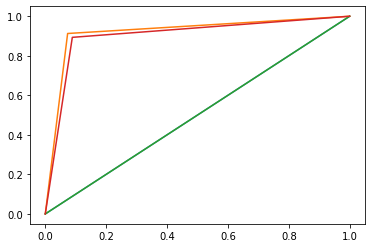

In [ ]:
easy5 = EasyEnsembleClassifier(base_estimator=LGBMClassifier(random_state=42), random_state=42, replacement=True)
easy5.fit(X_train_svm, y_train_svm)
evaluate(easy5, X_test_svm, y_test_svm)
print("=======================================================================")

print(classification_report(y_train_svm, easy5.predict(X_train_svm)))
print(confusion_matrix(y_train_svm, easy5.predict(X_train_svm)))
print('Train Recall Score = ',recall_score(y_train_svm, easy5.predict(X_train_svm)))
print('Train Precision Score = ',precision_score(y_train_svm, easy5.predict(X_train_svm)))
print("Train f1 score =", f1_score(y_train_svm, easy5.predict(X_train_svm)))
print("=======================================================================")

train_auc_roc_curve(easy5, X_test_svm, y_test_svm, X_train_svm, y_train_svm)
print("=======================================================================")

test_auc_roc_curve(easy5, X_test_svm, y_test_svm, X_train_svm, y_train_svm)

In [ ]:
comparison = pd.DataFrame()
comparison['Models'] = ['Default Decision Tree without Oversampling', 'Tuned Decision Tree without Oversampling',
                        'Default Decision Tree with Oversampling', 'Tuned Decision Tree with Oversampling',
                        'Default Random Forest without Oversampling', 'Tuned Random Forest without Oversampling',
                        'Default Random Forest with Oversampling', 'Tuned Random Forest with Oversampling',
                        'Default Easy Ensemble Classifier without Oversampling', 'Tuned Easy Ensemble Classifier without Oversampling',
                        'Default Easy Ensemble Classifier with Oversampling', 'Tuned Easy Ensemble Classifier with Oversampling',
                        'Default Easy Ensemble Classifier with LGBMClassifier as base estimator with Oversampling']
                        
comparison['f1 score'] = [f1_score(y_test, dtree1.predict(X_test)), f1_score(y_test, dtree2.predict(X_test)),
                          f1_score(y_test_svm,dtree3.predict(X_test_svm)), f1_score(y_test_svm,dtree4.predict(X_test_svm)),
                          f1_score(y_test, rfc1.predict(X_test)), f1_score(y_test, rfc2.predict(X_test)),
                          f1_score(y_test_svm, rfc3.predict(X_test_svm)), f1_score(y_test_svm, rfc4.predict(X_test_svm)),
                          f1_score(y_test, easy1.predict(X_test)), f1_score(y_test, easy2.predict(X_test)),
                          f1_score(y_test_svm, easy3.predict(X_test_svm)), f1_score(y_test_svm, easy4.predict(X_test_svm)),
                          f1_score(y_test_svm, easy5.predict(X_test_svm))]

In [ ]:
comparison.sort_values(by='f1 score', ascending=True)

,Models,f1 score
5,Tuned Random Forest without Oversampling,0.395847
9,Tuned Easy Ensemble Classifier without Oversam...,0.572911
0,Default Decision Tree without Oversampling,0.595762
1,Tuned Decision Tree without Oversampling,0.651384
4,Default Random Forest without Oversampling,0.658813
8,Default Easy Ensemble Classifier without Overs...,0.700292
7,Tuned Random Forest with Oversampling,0.822654
10,Default Easy Ensemble Classifier with Oversamp...,0.833238
11,Tuned Easy Ensemble Classifier with Oversampling,0.841532
2,Default Decision Tree with Oversampling,0.852627


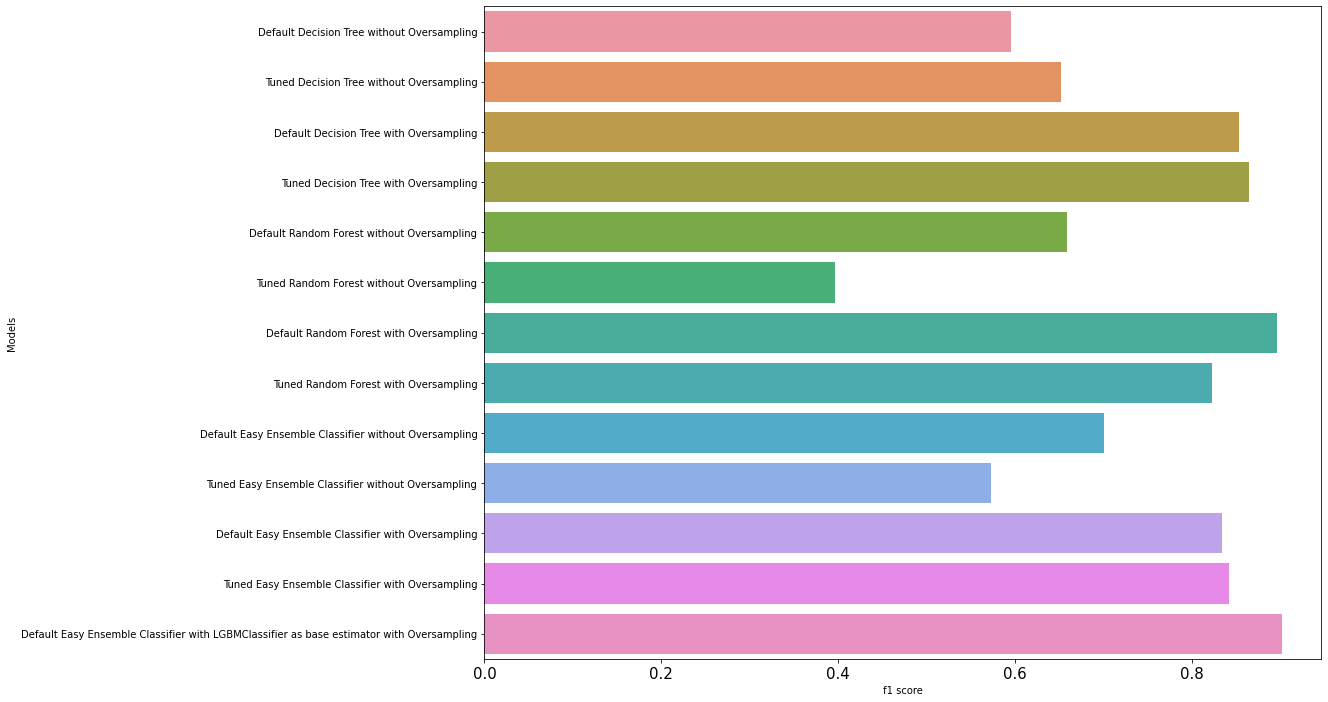

In [ ]:
plt.figure(figsize=(15,12))
plt.xticks(fontsize=15)
plt.yticks(fontsize=10)
sns.barplot(x='f1 score', y = 'Models', data = comparison)